# Initial Comparison

We run integrated gradients and activation patching on the same model and dataset, to compare attribution scores.

- Model: GPT2-Small (12 layers, 12 attention heads per layer, embedding size 768, 3,072 neurons per MLP layer)
- Dataset: Indirect Object Identification task

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.utils import get_device

from attribution_methods import activation_patching, highlight_components, integrated_gradients
from testing import Task, TaskDataset, logit_diff_metric, average_correlation, measure_overlap
from plotting import plot_attn_comparison, plot_correlation_comparison, plot_mean_diff

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.empty_cache()

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


## Experiment

In [4]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=100)

clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507,  0.1791,  4.2971,  2.9955, -0.7016, -2.1907, -3.5684,
        -4.4879, -1.2934, -3.8906, -0.6969, -0.8222,  0.0708,  0.2167,  4.4769,
         1.0375, -1.2644,  0.9309,  2.8114,  0.9975,  2.4103,  2.6244,  0.0125,
        -0.8472, -0.6130, -1.1623, -0.5109,  3.0073,  0.6154, -1.1229,  0.2680,
        -2.7379,  5.2855,  2.5019,  0.3219, -1.3112,  1.2942, -2.1428,  3.1053,
         1.6090,  3.1023,  1.8912,  0.4089,  4.0511,  2.5005,  3.5176, -1.5472,
         2.2213, -0.8523,  0.6682,  0.4244,  0.8053,  3.2905,  0.7295,  0.9946,
        -3.6073, -2.2671,  1.7894, -0.6390,  0.6320, -1.5326,  1.3206, -0.1224,
         0.1692,  1.9326,  3.1771,  1.1320, -0.0876,  3.1172,  2.3856,  3.2836,
        -2.0859,  3.6953,  2.8493, -2.4261,  1.1299,  0.1732, -1.4748, -2.1046,
        -0.6516, -0.6167,  0.0277, -1.7128,  0.6374,  2.6353, -1.4080,  3.2583,
         0.6919,

In [5]:
zero_baseline_cache_dict = dict()
for k, v in clean_cache.cache_dict.items():
    zero_baseline_cache_dict[k] = torch.zeros_like(v)
zero_baseline_cache = ActivationCache(zero_baseline_cache_dict, model)

ig_mlp_results, ig_attn_results = integrated_gradients(
    model,
    clean_tokens,
    zero_baseline_cache,
    clean_cache,
    logit_diff_metric,
    labels,
)


# from transformer_lens.utils import get_act_name
# from attribution_methods import compute_layer_to_output_attributions

# torch.set_grad_enabled(True)

# # Standard integrated gradients with zero baseline

# n_samples = clean_tokens.size(0)

# ig_mlp_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.d_mlp)
# ig_attn_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.n_heads)

# # Calculate integrated gradients for each layer
# for layer in range(model.cfg.n_layers):

#     # Gradient attribution on heads
#     hook_name = get_act_name("result", layer)
#     target_layer = model.hook_dict[hook_name]
#     prev_layer_hook = get_act_name("z", layer)
#     prev_layer = model.hook_dict[prev_layer_hook]

#     # Use zero activations as the corrupt
#     layer_input = torch.zeros_like(layer_input)
#     layer_baseline = clean_cache[prev_layer_hook]

#     # Shape [batch, seq_len, d_head, d_model]
#     attributions = compute_layer_to_output_attributions(
#         model,
#         clean_tokens,
#         layer_input,
#         layer_baseline,
#         target_layer,
#         prev_layer,
#         logit_diff_metric,
#         labels,
#     )

#     # Calculate score based on mean over each embedding, for each token
#     per_token_score = attributions.mean(dim=3)
#     score = per_token_score.mean(dim=1)
#     ig_attn_results[:, layer] = score

#     # Gradient attribution on MLP neurons
#     hook_name = get_act_name("post", layer)
#     target_layer = model.hook_dict[hook_name]
#     prev_layer_hook = get_act_name("mlp_in", layer)
#     prev_layer = model.hook_dict[prev_layer_hook]

#     layer_input = clean_cache[prev_layer_hook]
#     layer_baseline = torch.zeros_like(layer_input)

#     # Shape [batch, seq_len, d_model]
#     attributions = compute_layer_to_output_attributions(
#         model,
#         clean_tokens,
#         layer_input,
#         layer_baseline,
#         target_layer,
#         prev_layer,
#         logit_diff_metric,
#         labels,
#     )
#     score = attributions.mean(dim=1)
#     ig_mlp_results[:, layer] = score


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-2.3117e-01,  3.6102e-02, -3.0719e-01,  2.1320e-01,  1.8795e-01,
        -4.3097e-01, -3.7518e-01,  2.7115e-01,  4.4686e+00, -1.1150e-01,
        -1.7191e-01,  5.8448e-01,  3.4518e+00, -8.2562e-02,  6.8106e-01,
         3.3526e-01, -9.9698e-02,  3.0928e-01,  3.7595e-01, -1.1244e-01,
        -1.4868e-02,  4.3999e-01,  1.7113e-02,  2.0678e-01,  2.1274e-01,
         2.7953e-01,  4.3948e-01, -6.1429e-02, -5.2967e-01,  2.0603e-01,
         2.9338e-02,  2.4162e-01, -2.7459e-01, -2.4940e-02,  2.8342e-01,
         2.9081e-01,  1.1620e-01,  5.3059e-02, -2.7999e-02,  2.2944e-01,
         2.6297e-01, -4.7922e+00,  1.0546e+00, -9.8640e-02,  6.1137e-01,
         1.4469e-01, -2.5010e-01, -1.0046e+00, -1.4854e-01, -1.1812e+00,
        -3.2850e+00,  9.1023e-02,  1.2862e+01,  1.8781e-01, -6.6630e+00,
         1.4640e-01,  1.0590e+00, -3.0905e-01,  9.6648e-02, -2.4374e-01,
        -1.6660e-01,  7.7175e+00, -2.0437e-01,  6.2080e-01, -5.352

In [6]:
torch.save(ig_mlp_results, "results/initial/ig_mlp_zero_results.pt")
torch.save(ig_attn_results, "results/initial/ig_attn_zero_results.pt")

In [ ]:
# Activation patching
ap_mlp_results, ap_attn_results = activation_patching(model, clean_tokens, clean_logit_diff, corrupted_cache, corrupted_logit_diff, logit_diff_metric, labels)

## Analysis

To evaluate the similarity between standard integrated gradients and activation patching, we:

- Visualise the attention heads highlighted by each method for the sample
- Plot the correlation between the attribution scores
- Measure the amount of overlap between highlighted components
- Visualise the mean-difference plot

### Specific example

In [ ]:
clean_input = "When John and Mary went to the store, John gave a bottle of milk to"
corrupted_input = "When John and Mary went to the store, Mary gave a bottle of milk to"
labels = torch.tensor([
    [model.to_tokens("Mary", prepend_bos=False).item(), 
     model.to_tokens("John", prepend_bos=False).item()]
])

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

In [6]:
ig_attn_results = torch.load("results/initial/ioi_ig_attn_zero_results.pt")
ig_mlp_results = torch.load("results/initial/ioi_ig_mlp_zero_results.pt")

ap_attn_results = torch.load("results/case_study/attn_clean_corrupt.pt")
ap_mlp_results = torch.load("results/case_study/mlp_clean_corrupt.pt")

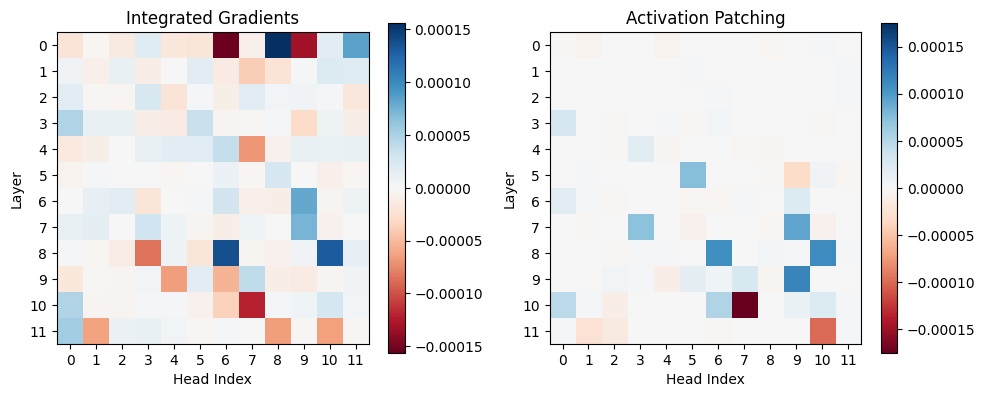

In [39]:
plot_attn_comparison(ig_attn_results, ap_attn_results, model)

In [47]:
import seaborn as sns
import numpy as np

def plot_correlation(x, y, x_label: str, y_label: str, title: str):
    assert x.size(0) == y.size(0)
    n_results = x.size(0)

    for i in range(n_results):
        xi = x[i].flatten().numpy()
        yi = y[i].flatten().numpy()
        sns.regplot(x=xi, y=yi)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(f"{title}")

        plt.tight_layout()
        plt.show()

        print(f"Correlation coefficient: {np.corrcoef(xi, yi)[0, 1]}")

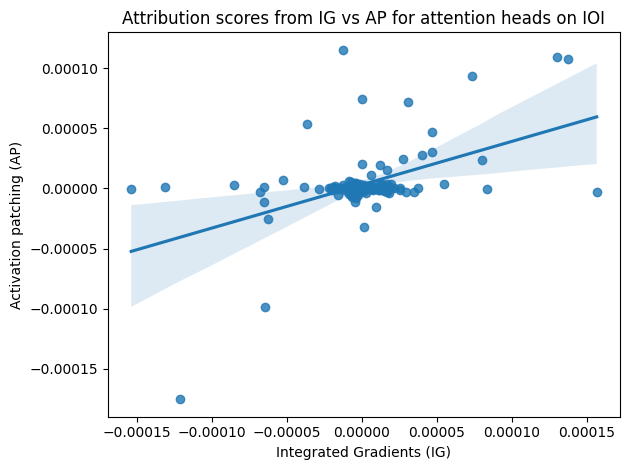

Correlation coefficient: 0.4884673573982641


In [48]:
plot_correlation(ig_attn_results, ap_attn_results, "Integrated Gradients (IG)", "Activation patching (AP)", "Attribution scores from IG vs AP for attention heads on IOI")

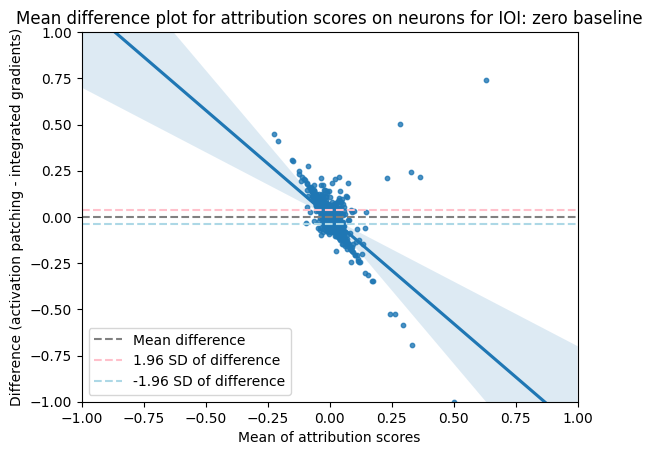

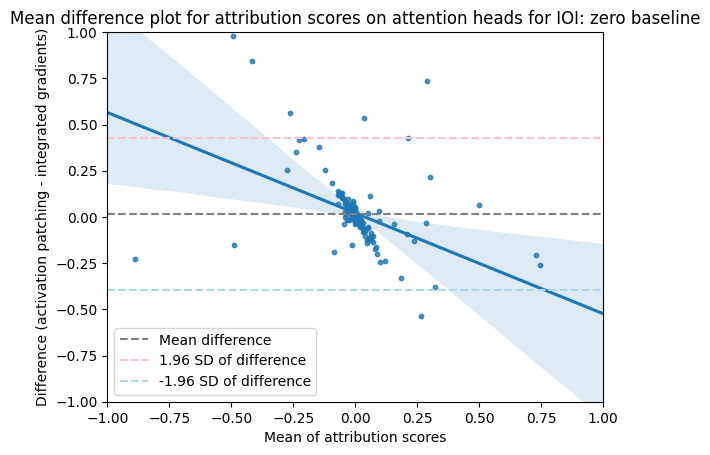

In [13]:
plot_mean_diff(ig_mlp_results, ap_mlp_results, "Mean difference plot for attribution scores on neurons for IOI: zero baseline")
plot_mean_diff(ig_attn_results, ap_attn_results, "Mean difference plot for attribution scores on attention heads for IOI: zero baseline")

### General results

In [7]:
ig_attn_results = torch.load("results/initial/ig_attn_zero_results.pt")
ig_mlp_results = torch.load("results/initial/ig_mlp_zero_results.pt")

# Same runs as in experiment 4 with latent components, patching from corrupt to clean
ap_mlp_results = torch.load("results/aligned/ioi/ap_mlp.pt")
ap_attn_results = torch.load("results/aligned/ioi/ap_attn.pt")


In [8]:
ig_attn_results.shape, ap_attn_results.shape, ig_mlp_results.shape, ap_mlp_results.shape

(torch.Size([100, 12, 12]),
 torch.Size([100, 12, 12]),
 torch.Size([100, 12, 3072]),
 torch.Size([100, 12, 3072]))

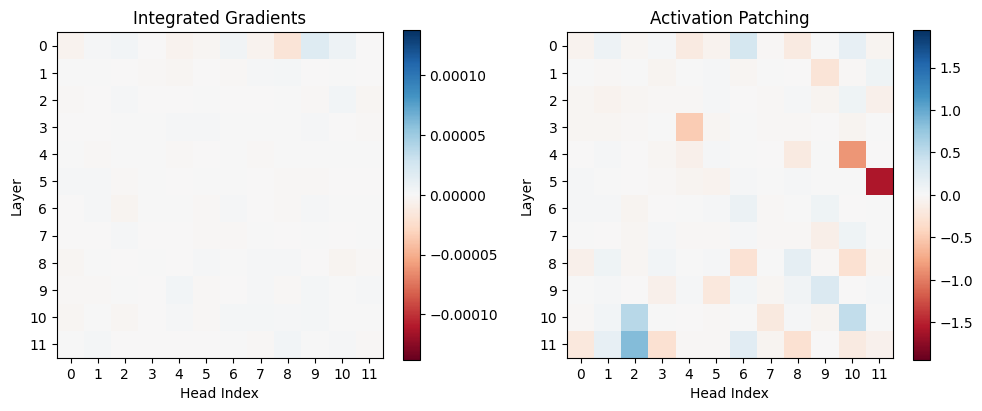

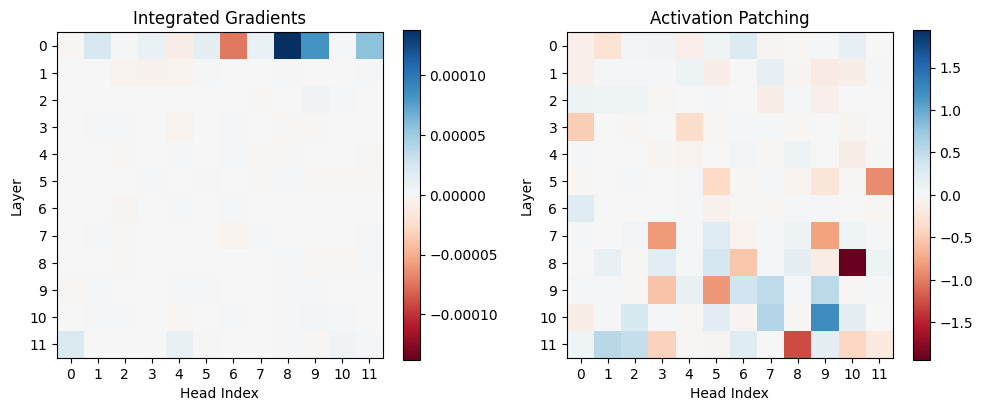

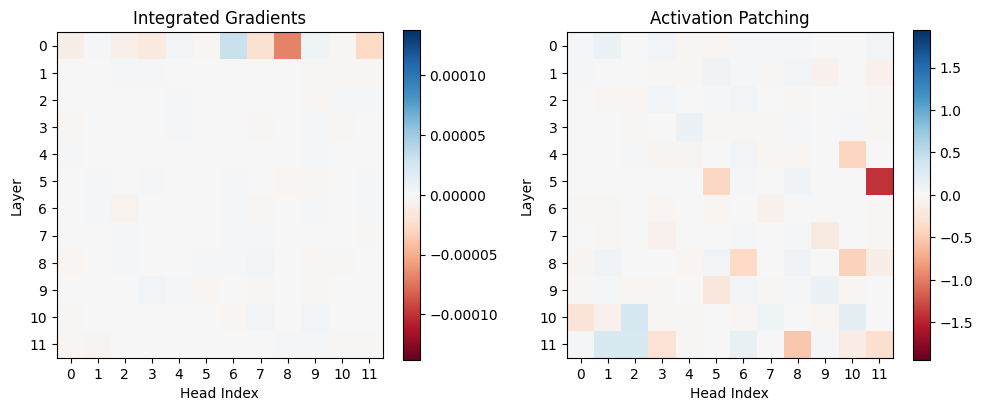

In [10]:
plot_attn_comparison(ig_attn_results[:3], ap_attn_results[:3], model)

In [11]:
# Mean and standard deviation
print(f"Mean attribution score for IG attention heads: {torch.mean(torch.mean(ig_attn_results, dim=(1,2)))}")
print(f"Standard deviation of attribution score for IG attention heads: {torch.mean(torch.std(ig_attn_results, dim=(1,2)))}")

print(f"Mean attribution score for IG MLP neurons: {torch.mean(torch.mean(ig_mlp_results, dim=(1,2)))}")
print(f"Standard deviation of attribution score for IG MLP neurons: {torch.mean(torch.std(ig_mlp_results, dim=(1,2)))}")

print(f"Mean attribution score for AP attention heads: {torch.mean(torch.mean(ap_attn_results, dim=(1,2)))}")
print(f"Standard deviation of attribution score for AP attention heads: {torch.mean(torch.std(ap_attn_results, dim=(1,2)))}")

print(f"Mean attribution score for AP MLP neurons: {torch.mean(torch.mean(ap_mlp_results, dim=(1,2)))}")
print(f"Standard deviation of attribution score for AP MLP neurons: {torch.mean(torch.std(ap_mlp_results, dim=(1,2)))}")

Mean attribution score for IG attention heads: 8.965441793407081e-07
Standard deviation of attribution score for IG attention heads: 1.5100118616828695e-05
Mean attribution score for IG MLP neurons: 5.609561412711628e-06
Standard deviation of attribution score for IG MLP neurons: 0.0006846731412224472
Mean attribution score for AP attention heads: -0.019641924649477005
Standard deviation of attribution score for AP attention heads: 0.23508165776729584
Mean attribution score for AP MLP neurons: 1.812431582948193e-05
Standard deviation of attribution score for AP MLP neurons: 0.008947634138166904


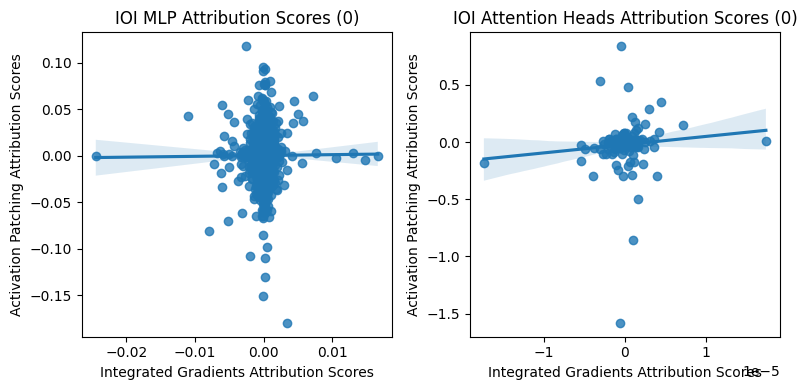

Correlation coefficient for neurons: 0.004602526112549891
Correlation coefficient for attention heads: 0.09676838108969729


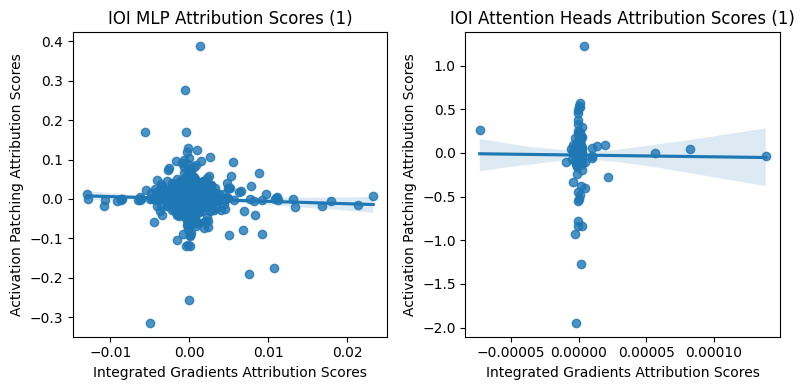

Correlation coefficient for neurons: -0.03673036961988327
Correlation coefficient for attention heads: -0.010291912469174741


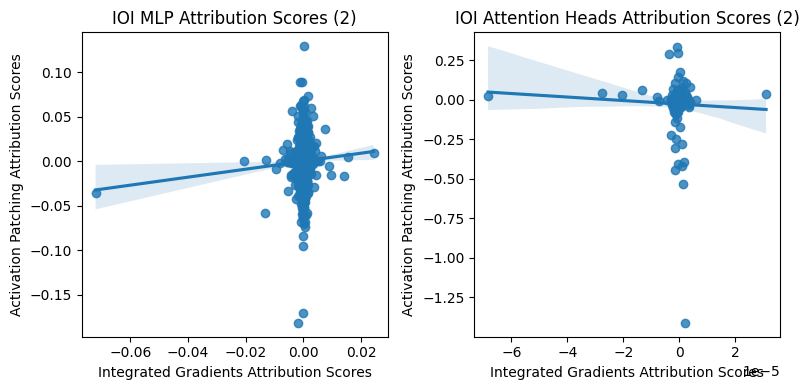

Correlation coefficient for neurons: 0.04166525316550247
Correlation coefficient for attention heads: -0.04953470187433006
Average correlation between MLP neuron scores: -0.028726250216542473
Standard deviation of correlation between MLP neuron scores: 0.07142099822721198
Average correlation between attention head scores: -0.05580745759367625
Standard deviation of correlation between attention head scores: 0.1703066009796817


In [12]:
plot_correlation_comparison(ig_mlp_results[:3], ap_mlp_results[:3], ig_attn_results[:3], ap_attn_results[:3], Task.IOI)

mlp_corr_avg, mlp_corr_std = average_correlation(ig_mlp_results, ap_mlp_results)
print(f"Average correlation between MLP neuron scores: {mlp_corr_avg}")
print(f"Standard deviation of correlation between MLP neuron scores: {mlp_corr_std}")

attn_corr_avg, attn_corr_std = average_correlation(ig_attn_results, ap_attn_results)
print(f"Average correlation between attention head scores: {attn_corr_avg}")
print(f"Standard deviation of correlation between attention head scores: {attn_corr_std}")

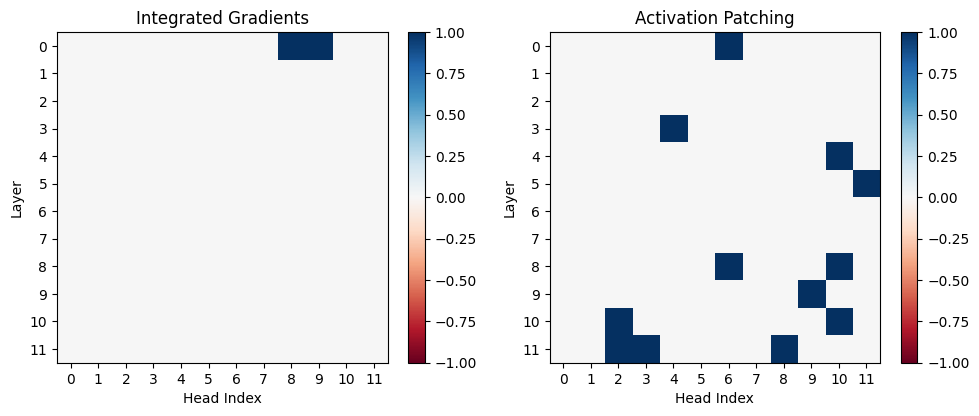

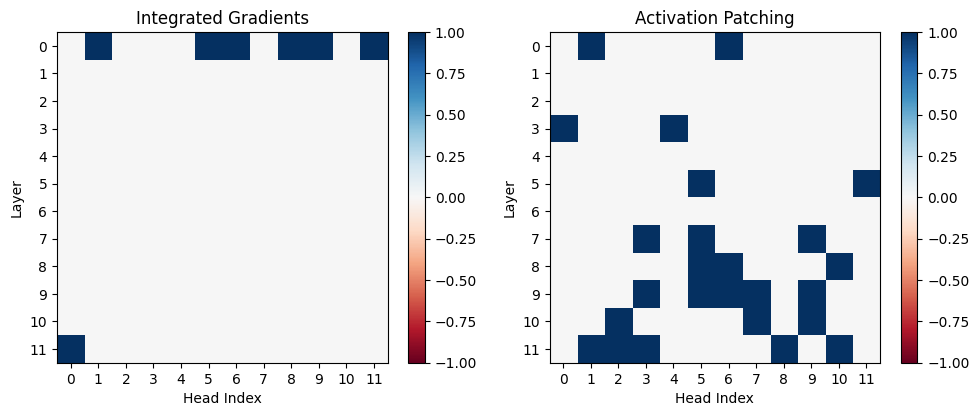

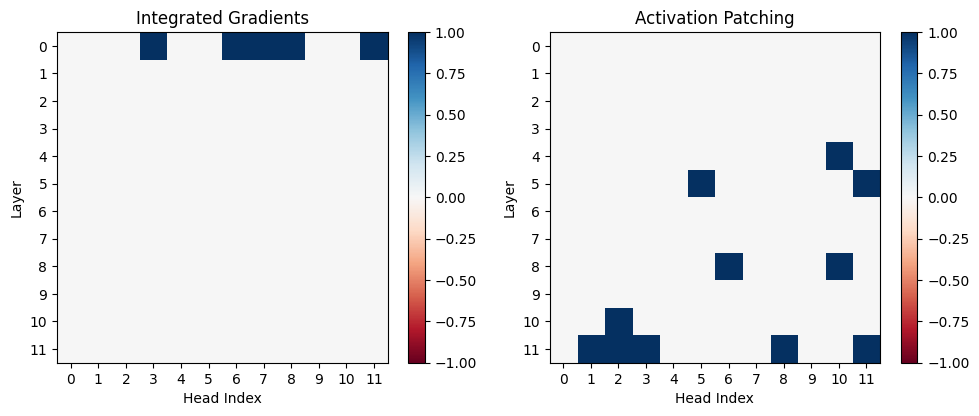

Average overlap between IG and AP highlighted attention heads: 0.04337438941001892


In [13]:
ig_attn_significant, _ = highlight_components(ig_attn_results)
ap_attn_significant, _ = highlight_components(ap_attn_results)

plot_attn_comparison(ig_attn_significant[:3].int(), ap_attn_significant[:3].int(), model)

attn_overlap = measure_overlap(ig_attn_significant, ap_attn_significant)
print(f"Average overlap between IG and AP highlighted attention heads: {attn_overlap.mean()}")

In [14]:
ig_mlp_significant, _ = highlight_components(ig_mlp_results)
ap_mlp_significant, _ = highlight_components(ap_mlp_results)

mlp_overlap = measure_overlap(ig_mlp_significant, ap_mlp_significant)
print(f"Average overlap between IG and AP highlighted MLP neurons: {mlp_overlap.mean()}")

Average overlap between IG and AP highlighted MLP neurons: 0.08427179604768753


In [17]:
from testing import print_jaccard_multi

print_jaccard_multi(ig_mlp_results, ig_attn_results, ap_mlp_results, ap_attn_results)

Average Jaccard similarity score for MLP: 0.15668156743049622
Average Jaccard similarity score for Attention: 0.27463918924331665
Jaccard similarity std for MLP: 0.04751163721084595
Jaccard similarity std for Attention: 0.4079735279083252
